## Multi-Class Classification

### Import Libraries

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import xgboost as xgb

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

import numpy as np

from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import warnings

### Import Data and Preprocessing

In [35]:
file = "Data_Cleaning/airport_1.csv"
df = pd.read_csv(file, index_col = 0)
df = df[~df.isna()]
#df.describe()
# 66554 159278

In [36]:
features_cls = list(df.columns)
features_cls.remove("ARR_DEL15")
features_cls.remove("ARR_DEL")
features_cls.remove("CARRIER_DELAY")
features_cls.remove("WEATHER_DELAY")
features_cls.remove("NAS_DELAY")
features_cls.remove("SECURITY_DELAY")
features_cls.remove("LATE_AIRCRAFT_DELAY")
col_target_cls = "ARR_DEL15"

In [37]:
delay_columns = ["CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"]

# Apply the function along the DataFrame's rows, but only for the specified columns
df['ARR_DEL_CAT'] = df[delay_columns].idxmax(axis=1)
df["ARR_DEL_CAT"] = df['ARR_DEL_CAT'].map({"CARRIER_DELAY": 1, "WEATHER_DELAY": 2, "NAS_DELAY": 3, "SECURITY_DELAY": 4, "LATE_AIRCRAFT_DELAY": 5})
df["ARR_DEL_CAT"] = df['ARR_DEL_CAT'].fillna(0)
classes_included = [1, 2, 3, 4, 5]
df = df[df.ARR_DEL_CAT.isin(classes_included)]

X_train, X_test, y_train, y_test = train_test_split(df[features_cls], df["ARR_DEL_CAT"], test_size=0.33, stratify=df["ARR_DEL_CAT"], random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42, n_jobs=-1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

/var/folders/6x/002d9wvx0ln2cycd86pjbd740000gn/T/ipykernel_84468/3461351169.py:4: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['ARR_DEL_CAT'] = df[delay_columns].idxmax(axis=1)
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_s

### Define a function to perform model training and hyperparameter tuning

In [38]:
def train_and_tune_model(model, param_grid, X_train, y_train, cv=5):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_predictions = predictions = best_model.predict(X_test)
        best_conf_matrix = confusion_matrix(y_test, predictions)
        return best_model, best_params, best_score, best_conf_matrix

# CART
parameters_cart = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [5, 10, 20],
    'model__min_samples_leaf': [5, 10, 20, 25]
}
model_cart = DecisionTreeClassifier()

# Random Forest
parameters_random_forest = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_features': ['auto', 'sqrt'],
    'model__max_depth': [5, 10, 20],
    'model__min_samples_leaf': [5, 10, 20, 25]
}
model_random_forest = RandomForestClassifier()

# Logistic Regression
parameters_logistic_regression = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'model__max_iter': [1000]
}
model_logistic_regression = LogisticRegression()

In [39]:
# Define your models and parameter grids
models_and_parameters = {
    'CART': (model_cart, parameters_cart),
    'Random Forest': (model_random_forest, parameters_random_forest),
    'Logistic Regression': (model_logistic_regression, parameters_logistic_regression),
}

# Dictionary to store the results
best_models = {}

# Iterate over each model and train/tune them
for model_name, (model, parameters) in models_and_parameters.items():
    print(f"Training and tuning {model_name}...")
    best_model, best_params, best_score, best_conf_matrix = train_and_tune_model(model, parameters, X_train_resampled, y_train_resampled)
    best_models[model_name] = {
        'Best Model': best_model,
        'Best Parameters': best_params,
        'Best Score': best_score,
        'Best Confusion Matrix': best_conf_matrix
    }

# After training, you can access the best models, parameters, and scores for each
for model_name, results in best_models.items():
    print(f"\n{model_name} results:")
    print(f"Best Model: {results['Best Model']}")
    print(f"Best Parameters: {results['Best Parameters']}")
    print(f"Best Score: {results['Best Score']}")
    print(f"Confusion Matrix: {results['Best Confusion Matrix']}")

Training and tuning CART...


/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:767

Training and tuning Random Forest...


/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:767

Training and tuning Logistic Regression...


/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/janphilippgirgott/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/utils/validation.py:767


CART results:
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(max_depth=20, min_samples_leaf=5))])
Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 20, 'model__min_samples_leaf': 5}
Best Score: 0.6866766467065869
Confusion Matrix: [[1193  216  300   11  682]
 [ 165   80   39    0  145]
 [ 387   95 2470    1  338]
 [   5    2    0    4    3]
 [ 764  182  295   14 1174]]

Random Forest results:
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=20, max_features='auto',
                                        min_samples_leaf=5,
                                        n_estimators=200))])
Best Parameters: {'model__max_depth': 20, 'model__max_features': 'auto', 'model__min_samples_leaf': 5, 'model__n_estimators': 200}
Best Score: 0.7206586826347305
Confusion Matrix: [[1457  190  170   23  562]
 [ 144  113   22    5 

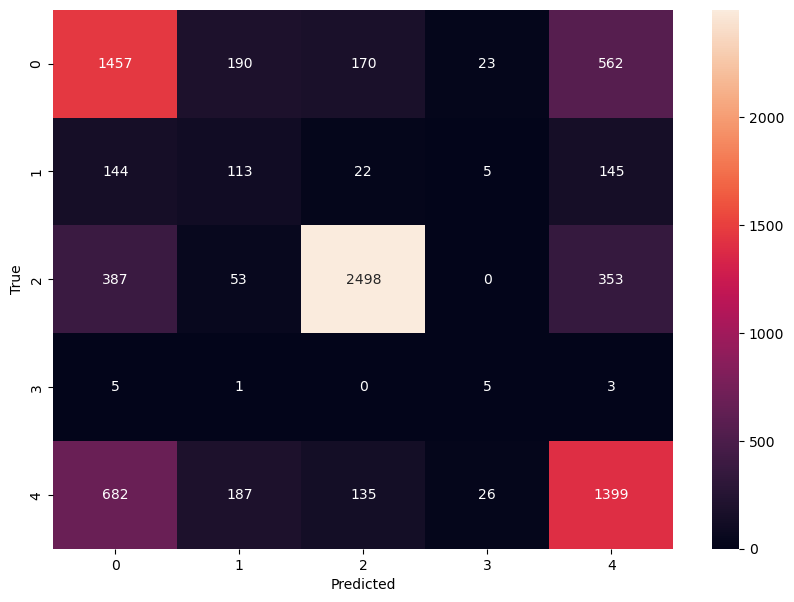

In [40]:
plt.figure(figsize=(10,7))
sns.heatmap(best_models["Random Forest"]["Best Confusion Matrix"], annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [41]:
best_models

{'CART': {'Best Model': Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   DecisionTreeClassifier(max_depth=20, min_samples_leaf=5))]),
  'Best Parameters': {'model__criterion': 'gini',
   'model__max_depth': 20,
   'model__min_samples_leaf': 5},
  'Best Score': 0.6866766467065869,
  'Best Confusion Matrix': array([[1193,  216,  300,   11,  682],
         [ 165,   80,   39,    0,  145],
         [ 387,   95, 2470,    1,  338],
         [   5,    2,    0,    4,    3],
         [ 764,  182,  295,   14, 1174]])},
 'Random Forest': {'Best Model': Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   RandomForestClassifier(max_depth=20, max_features='auto',
                                          min_samples_leaf=5,
                                          n_estimators=200))]),
  'Best Parameters': {'model__max_depth': 20,
   'model__max_features': 'auto',
   'model__min_samples_leaf': 5,
   'model__n_estima

In [68]:
importance = pd.DataFrame({"Feature": X_train.columns, 
                           "CART": best_models["CART"]["Best Model"][1].feature_importances_, 
                           "Random Forest": best_models["Random Forest"]["Best Model"][1].feature_importances_})
importance = importance.sort_values(by="Random Forest", ascending=False)
importance

,Feature,CART,Random Forest
1,DEP_DEL15,0.157983,0.162796
4,AIRLINE_FLIGHTS_MONTH,0.097471,0.063661
13,AWND,0.102145,0.060988
3,NUMBER_OF_SEATS,0.039035,0.048332
12,TMAX,0.061177,0.045072
...,...,...,...
129,PREVIOUS_AIRPORT_Fresno Air Terminal,0.000000,0.000000
125,PREVIOUS_AIRPORT_Fanning Field,0.000000,0.000000
123,PREVIOUS_AIRPORT_Fairbanks International,0.000000,0.000000
121,PREVIOUS_AIRPORT_Erie International,0.000000,0.000000
